In [6]:
library(DESeq2)
library(tidyverse)
library(ggrepel)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [7]:
setwd('/home/wpy/stereoseq/20240402-ZNF296')
rna_data <- read.csv('genename raw counts.csv', row.names = 1)
head(rna_data)

,NC_1,NC_2,NC_3,ZNF296_1,ZNF296_2,ZNF296_3
,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,1,2,1,5,3,5
A1BG-AS1,19,7,29,20,42,28
A1CF,25,23,30,2,0,4
A2M,7,8,9,5,2,3
A2M-AS1,9,8,3,7,9,11
A2ML1,0,0,0,2,0,1


In [8]:
meta <- data.frame(
    sampleName = c('NC_1', 'NC_2', 'NC_3', 'ZNF296_1', 'ZNF296_2', 'ZNF296_3'),
    group = c(rep('control', 3), rep('ZNF296 KO', 3))
)

dds <- DESeqDataSetFromMatrix(
    countData = rna_data[, meta$sampleName],
    colData = meta,
    design = ~ group
)
print(dds@assays@data@listData$counts)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



                            NC_1   NC_2   NC_3 ZNF296_1 ZNF296_2 ZNF296_3
A1BG                           1      2      1        5        3        5
A1BG-AS1                      19      7     29       20       42       28
A1CF                          25     23     30        2        0        4
A2M                            7      8      9        5        2        3
A2M-AS1                        9      8      3        7        9       11
A2ML1                          0      0      0        2        0        1
A2ML1-AS1                      0      0      0        0        0        0
A2ML1-AS2                      0      0      0        0        0        0
A2MP1                          6      7      9        0        0        0
A3GALT2                        0      4      1        0        0        1
A4GALT                       363    423    368     1001      912      811
A4GNT                         15      8     13        4        1        3
AA06                           0      

In [9]:
keep <- rowSums(counts(dds)) >= 2 * ncol(counts(dds))
dds <- dds[keep, ]
dds <- DESeq(dds,quiet = F)
res <- results(dds, contrast=c("group", 'ZNF296 KO', 'control'))  #指定提取为exp/ctr结果
resOrdered <- res[order(res$padj), ]  #order根据padj从小到大排序结果
tempDEG <- as.data.frame(resOrdered)
DEG_DEseq2 <- na.omit(tempDEG)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



In [49]:
degs_all <- DEG_DEseq2
degs_all$gene <- row.names(degs_all)

m_df <- msigdbr(species = "Homo sapiens", category = "H")
mark_inf <- m_df %>%
  filter(gs_name == 'HALLMARK_INTERFERON_GAMMA_RESPONSE' | gs_name == 'HALLMARK_INTERFERON_ALPHA_RESPONSE') %>%
  pull(gene_symbol)
mark_inf <- degs_all[mark_inf,] %>% filter(log2FoldChange < -1 & padj < 0.05) %>% row.names(.)
mark_emt <- m_df %>%
  filter(gs_name == 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION') %>%
  pull(gene_symbol)
mark_emt <- degs_all[mark_emt,] %>% filter(log2FoldChange < -1 & padj < 0.05) %>% row.names(.)
mark = c(mark_inf, mark_emt)

degs_all$group = 'Insignificant'
degs_all$group[degs_all$log2FoldChange < -2] = 'Low Express'
degs_all$group[degs_all$log2FoldChange > 2] = 'High Express'
degs_all$group[degs_all$padj > 0.05] = 'Insignificant'
degs_all$group[degs_all$gene %in% mark_inf & degs_all$log2FoldChange < -2] = 'IFN Response Pathway'
degs_all$group[degs_all$gene %in% mark_emt & degs_all$log2FoldChange < -2] = 'EMT Pathway'
degs_all$group = factor(degs_all$group,levels = c('Insignificant', 'Low Express', 'High Express', 'IFN Response Pathway', 'EMT Pathway'))

options(repr.plot.width=5,repr.plot.height=4.5)
p <- ggplot(degs_all, aes(x=log2FoldChange, y=-log10(padj)))+
  geom_point(aes(color=group),size = 0.2)+
  scale_color_manual(values = c("grey", "green", "red", 'blue', 'orange'))+
  theme_classic()+
  geom_vline(xintercept=c(-2, 2),lty=4,col="black",lwd=0.8) +
  geom_hline(yintercept=c(-log(0.05)),lty=4,col="black",lwd=0.8) +
  theme(plot.title = element_text(size=20,hjust = 0.5))+
  coord_cartesian(xlim = c(-9,8))+
  geom_text_repel(data=subset(degs_all, gene %in% mark),aes(label=gene),size=2.5, max.overlaps = 10)

pdf('volcano.pdf',width = 5,height = 4.5)
print(p)
dev.off()

Warning message:
“ggrepel: 98 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [36]:
write.csv(degs_all, 'degs_all.csv', sep='\t')

Warning message in write.csv(degs_all, "degs_all.csv", sep = "\t"):
“attempt to set 'sep' ignored”


In [13]:
library(DOSE)
library(org.Hs.eg.db)
library(clusterProfiler)
library(enrichplot)
library(msigdbr)



DOSE v3.28.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select




clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:purrr’:

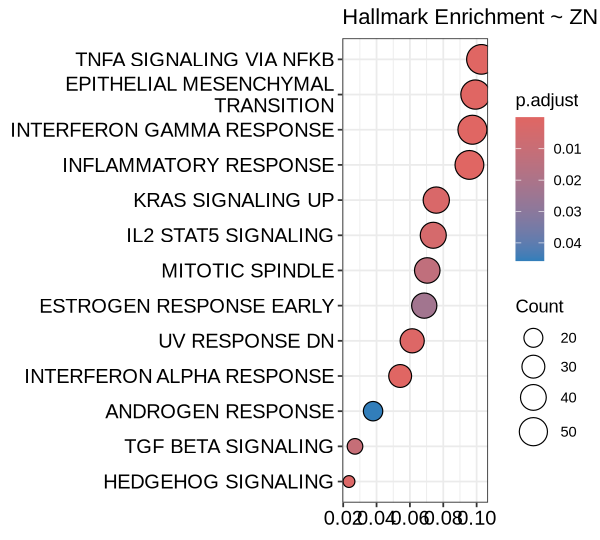

In [27]:
degs_sub <- degs_all[degs_all$padj < 0.05,]
degs_sub <- degs_sub[degs_sub$log2FoldChange < -1,]

m_df <- msigdbr(species = "Homo sapiens", category = "H")
hallmark_sets <- m_df %>% select(c('gs_name', 'gene_symbol'))
hallmark_enrich <- enricher(degs_sub$gene, TERM2GENE = hallmark_sets, pvalueCutoff = 0.05)

hallmark_enrich@result$Description <- gsub("HALLMARK_", "", hallmark_enrich@result$Description)
hallmark_enrich@result$color <- ifelse(hallmark_enrich@result$Description %in% c('EPITHELIAL_MESENCHYMAL_TRANSITION', 'INTERFERON_ALPHA_RESPONSE', 'INTERFERON_GAMMA_RESPONSE'), 'red', 'black')

dotplot(hallmark_enrich, showCategory=20) + ggtitle("Hallmark Enrichment ~ ZNF296 KO vs. Control") +
theme(axis.title.x = element_blank(),  # 去除 x 轴标签
      axis.title.y = element_blank())  # 去除 y 轴标签